# Diagnosis Model

It's time for transfer learning! 

Training a classifier on medical images is a crucial task to aid doctors and provide lower cost services to patients.

If we can build a classifier that can diagnosis a given disease and provide it to patients who can't afford a doctor as an app, we have a scalable business. In this homework, we're going to perform transfer learning to predict pneumonia in a patient, given their chest x-ray data.

Good Source: 
https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb

Source ImageAI:
https://github.com/OlafenwaMoses/ImageAI

### Import Library 

In [1]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras




Using TensorFlow backend.


In [2]:
from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


In [3]:

from keras import backend as K
#K.set_session
#K.set_image_dim_ordering('th')

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf

from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Let start

In [4]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [5]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [6]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)

In [7]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

# Data visualization Function 

In [8]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

In [9]:
def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [10]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    #print(classes)
    class_count = len(classes)
    #print(class_count)

    image_file_paths = {}
    
    for i in range(class_count):
        if(i>0):
            subdir_path = image_dir+"/"+classes[i]
            #print(subdir_path)
            subdir_files = os.listdir(subdir_path)

            subdir_file_count = len(subdir_files)

            subdir_file_mem = {}

            subdir_file_index = -1

            image_file_paths[classes[i]] = []

            for j in range(image_count_per_category):
                while subdir_file_index in subdir_file_mem:
                    subdir_file_index = random.randint(0, subdir_file_count-1)

                subdir_file_mem[subdir_file_index] = 1

                subdir_file_name = subdir_files[subdir_file_index]
                subdir_file_path = subdir_path+ "/" + subdir_file_name

                image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths

In [11]:
def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs

In [12]:
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()

In [13]:
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    print(directory)
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [14]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    print(master_directory)
    subdirectories = os.listdir(master_directory)
    print(subdirectories)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []
    i = 0
    for subdirectory in subdirectories:
        print(subdirectory)
        if(i>0):
            current_directory = os.path.join(master_directory, subdirectory)
            file_count = len(os.listdir(current_directory))
            subdirectory_names.append(subdirectory)
            subdirectory_file_counts.append(file_count)
        i+=1
    
    return subdirectory_names, subdirectory_file_counts

In [15]:
# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)

In [16]:
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)

In [17]:
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [18]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True

In [19]:
# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

# Preprocessing

In [20]:
reset_graph()
reset_callbacks()


In [21]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/"
output_directory = r"/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


figure_directory = r"/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/output/figures"

figure_directory = "/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/train
Number of Class:  3
-------------------------------------------------------Pneumonia-------------------------------------------------------


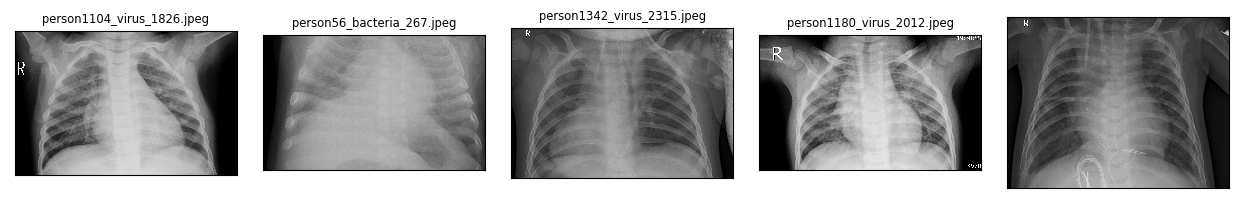


-------------------------------------------------------Normal-------------------------------------------------------


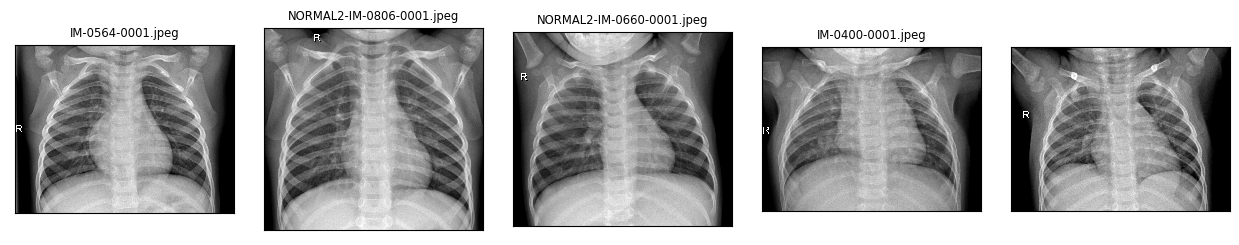


-------------------------------------------------------All Class Printed:3-------------------------------------------------------


In [22]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/train
['.DS_Store', 'PNEUMONIA', 'NORMAL']
.DS_Store
PNEUMONIA
NORMAL
/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/val
['.DS_Store', 'PNEUMONIA', 'NORMAL']
.DS_Store
PNEUMONIA
NORMAL
/Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/input/test
['.DS_Store', 'PNEUMONIA', 'NORMAL']
.DS_Store
PNEUMONIA
NORMAL


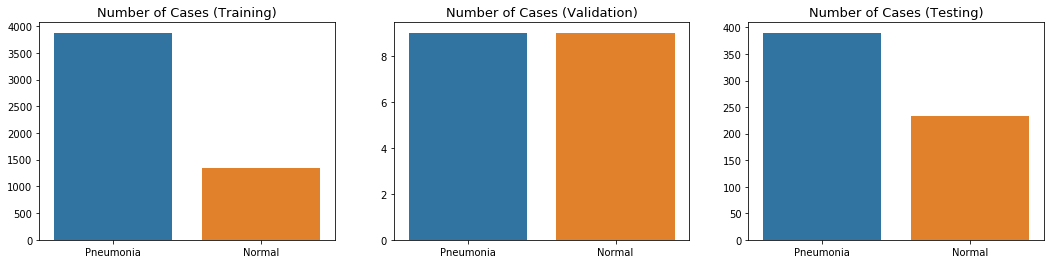

In [23]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

## Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and Dataset¶


In [24]:
# batch_size = 32

# target_size = (299, 299)
# color_mode = "rgb"


rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

## Training Files Configuration¶


In [26]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [27]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Removing empty folder: /Users/lourdesmontalvo/Documents/Projects/MakeMoneyML/Week4/data/output/models/2019-09-22 18-14-34


### Callbacks

In [28]:
reset_graph()
reset_callbacks()

In [29]:
print("Settting Callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks at ", date_time(1))

Settting Callbacks at  Timestamp: 2019-09-23 08:06:39
Set Callbacks at  Timestamp: 2019-09-23 08:06:41


In [30]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu',  input_shape=(3,150,150), padding='same',dim_ordering="th"))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', dim_ordering="th"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', dim_ordering="th"))

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(3,150,150),padding='same', dim_ordering="th"))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', dim_ordering="th"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', dim_ordering="th"))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', dim_ordering="th"))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', dim_ordering="th"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same',dim_ordering="th"))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same', dim_ordering="th"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu', dim_ordering="th"))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same',data_format='channels_first'))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu', dim_ordering="th"))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model

In [31]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
#     x = Dropout(0.5)(x)
    
#     x = GlobalAveragePooling2D()(x)
    
#     x = Dense(512, activation='relu')(x)
#     # x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
    model.summary()
        
    return model

## Training/Fine-Tuning Base Model-InceptionV3 for Fine-Tuning with New Class Labels¶


In [32]:
print("Getting Base Model", date_time(1))

model = get_conv_model()


Getting Base Model Timestamp: 2019-09-23 08:06:41


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(3, 150, 1..., padding="same", data_format="channels_first")`
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu", data_format="channels_first")`
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same", data_format="channels_first")`
  """
W0923 08:06:41.928829 4661781952 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d i

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 38, 38)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 38, 38)       

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid", activation="relu", data_format="channels_first")`
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [33]:
print("Starting Trainning Model", date_time(1))

print(train_generator)
steps_per_epoch=len(train_generator)
print(steps_per_epoch)
validation_steps=len(validation_generator)
print(validation_steps)


# lr = 0.00001
# optimizer=optimizers.Adam(lr=lr)

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100

model.compile(optimizer, loss=loss, metrics=metrics)


print(class_weight)

Starting Trainning Model Timestamp: 2019-09-23 08:06:42
32
1
[1.9448173  0.67303226]


In [34]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", date_time(1))

W0923 08:06:43.899212 4661781952 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0923 08:06:43.903003 4661781952 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/callbacks/tensorboard_v1.py:200: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0923 08:06:43.903749 4661781952 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/callbacks/tensorboard_v1.py:203: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100


ValueError: Error when checking input: expected conv2d_1_input to have shape (3, 150, 150) but got array with shape (150, 150, 3)

## Model Performance Visualization over the Epochs¶

In [ ]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()